# Setup:

In [29]:
!sudo apt-get -y install yosys > /dev/null
!sudo apt-get -y install ghostscript > /dev/null
!rm cmos_cells.lib*
!wget https://raw.githubusercontent.com/YosysHQ/yosys/master/examples/cmos/cmos_cells.lib

--2023-10-01 14:37:48--  https://raw.githubusercontent.com/YosysHQ/yosys/master/examples/cmos/cmos_cells.lib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1320 (1.3K) [text/plain]
Saving to: ‘cmos_cells.lib’

cmos_cells.lib      100%[===================>]   1.29K  --.-KB/s    in 0s      

2023-10-01 14:37:48 (105 MB/s) - ‘cmos_cells.lib’ saved [1320/1320]



In [30]:
from bs4 import BeautifulSoup
import re

def scale_svg(svg_object, scale=1.0):

    soup = BeautifulSoup(svg_object.data, 'lxml')
    svg_elt = soup.find("svg")
    w = svg_elt.attrs["width"].rstrip("pt")
    h = svg_elt.attrs["height"].rstrip("pt")

    ws = float(w)*scale
    hs = float(h)*scale

    svg_elt.attrs["width"] = f"{ws}pt"
    svg_elt.attrs["height"] = f"{hs}pt"
    svg_elt.attrs["viewbox"] = f"0.00 0.00 {ws} {hs}"

    g_elt = svg_elt.find("g")
    tf = g_elt.attrs["transform"]
    # non-greedy regex-search-and-replace
    tf2 = re.sub(
        "scale\(.*?\)",
        f"scale({scale} {scale})",
        tf
    )
    g_elt.attrs["transform"] = tf2

    svg_object.data = str(svg_elt)

    return svg_object

# Program File:

In [31]:
%%writefile mydesign.v
module control_logic(clk_t0, bottom, top, tccr0a, tccr0b, tifr0, tov0, direction, clear, count);
  //define input and output ports
  input clk_t0, bottom, top;
  input[7:0] tccr0a, tccr0b, tifr0;
  output tov0, direction, clear, count;

  //initialization
  wire dir_next, tov_next, clear_next;

  //always block will be executed at each and every positive edge of the clock
  always@(posedge clk_t0)
    begin
    clear_next = 0;
      if(tccr0b[3] == 0 && tccr0a[1] == 0 && tccr0a[0] == 0) begin  //Normal Mode
        begin
          if(top == 1)
            tov_next = 1;
        end
        dir_next = 0;
      end else if (tccr0b[3] == 0 && tccr0a[1] == 1 && tccr0a[0] == 1) begin  //CTC Mode
        begin
          if(top == 1)
            tov_next = 1;
        end
        dir_next = 0;
        begin
          if(top == 1)
            clear_next = 1;
        end
        dir_next = 0;
      end else if ((tccr0b[3] == 0 && tccr0a[1] == 1 && tccr0a[0] == 1) || (tccr0b[3] == 1 && tccr0a[1] == 1 && tccr0a[0] == 1)) begin  //Fast PWM Mode
        begin
          if(top == 1)
            tov_next = 1;
        end
        dir_next = 0;
      end else if ((tccr0b[3] == 0 && tccr0a[1] == 0 && tccr0a[0] == 1) || (tccr0b[3] == 1 && tccr0a[1] == 0 && tccr0a[0] == 1)) begin  //Phase Correct PWM Mode
        begin
          if(bottom == 1)
            tov_next = 1;
        end
        begin
          if(tifr0[0] == 1)
            dir_next = 0;
          else if(top == 1)
            dir_next = 1;
        end
      end
    end
    assign count = 1'b1;
    assign direction = dir_next;
    assign tov0 = tov_next;
    assign clear = clear_next;

  always@(negedge clk_t0)
    begin
    end
    assign count = 1'b0;

endmodule

Overwriting mydesign.v


# Synthesis Generation:

In [32]:
%%writefile synth_gate.ys
read_verilog mydesign.v
hierarchy -check
proc; opt; fsm; opt; memory; opt
techmap; opt
read_liberty -lib cmos_cells.lib
abc -liberty cmos_cells.lib
splitnets -ports; opt
stat
show -format dot
show -format svg

Overwriting synth_gate.ys


In [33]:
!yosys synth_gate.ys > synth_gate.log
!ls -la /root/.*.dot
!ls -la /root/.*.svg

!mv /root/.yosys_show.dot out_gate.dot
!mv /root/.yosys_show.svg out_gate.svg

-rw-r--r-- 1 root root 7520 Oct  1 14:37 /root/.yosys_show.dot
-rw-r--r-- 1 root root 57028 Oct  1 14:37 /root/.yosys_show.svg


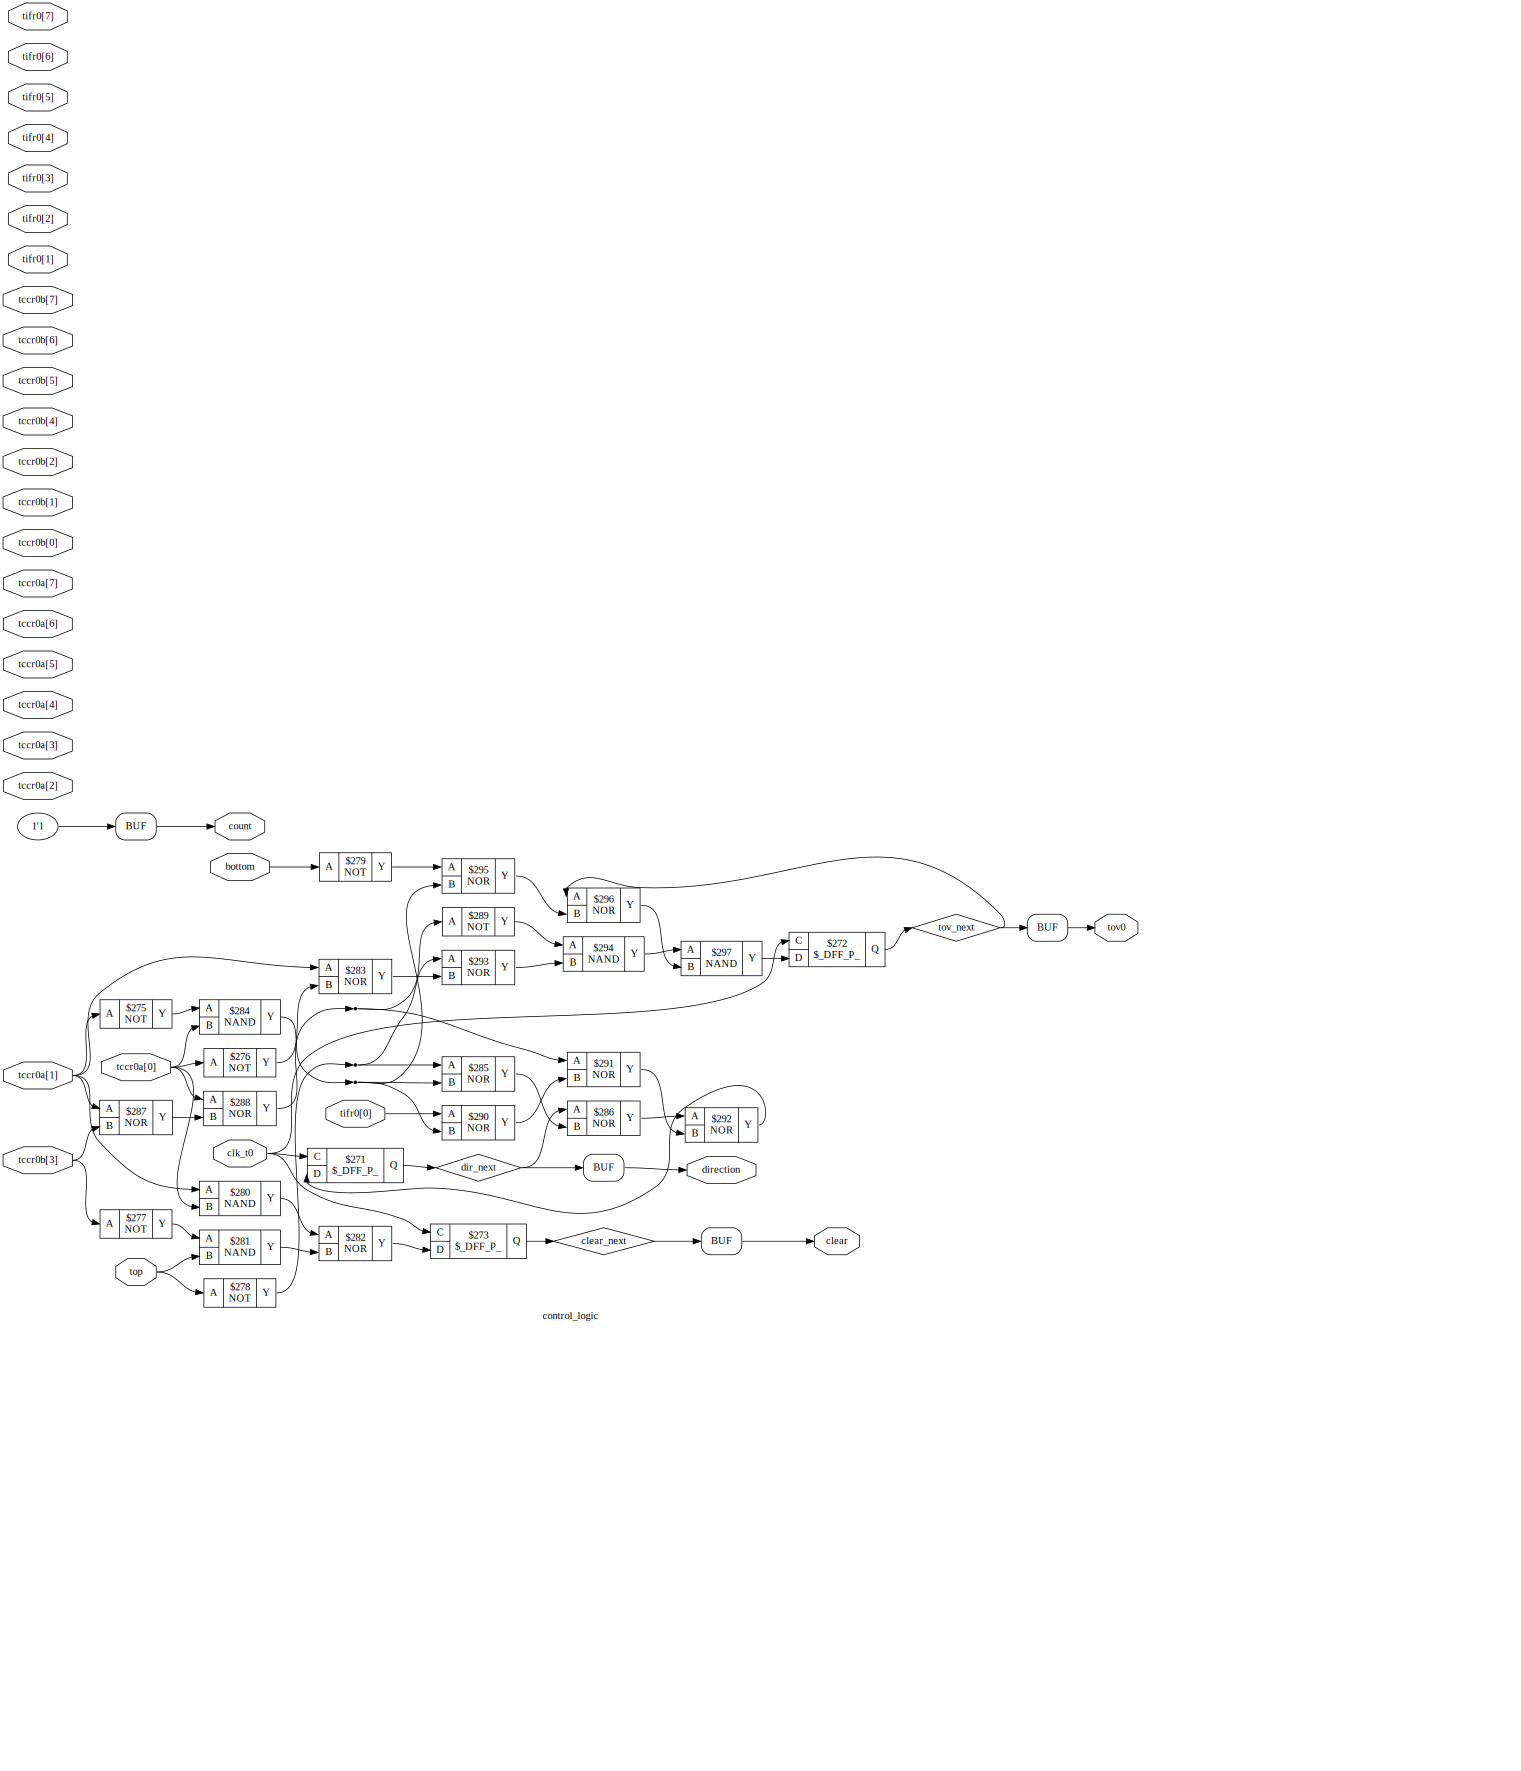

In [34]:
#print(open('mydesign.v').read())
from IPython.display import SVG
scale_svg(SVG('out_gate.svg'), scale=1)

# Circuit Analysis:

In [35]:
!sed -ne '/Printing statistics.$/{:a' -e 'n;p;ba' -e '}' synth_gate.log


=== control_logic ===

   Number of wires:                 57
   Number of wire bits:             57
   Number of public wires:          34
   Number of public wire bits:      34
   Number of memories:               0
   Number of memory bits:            0
   Number of processes:              0
   Number of cells:                 26
     $_DFF_P_                        3
     NAND                            5
     NOR                            12
     NOT                             6

16. Generating Graphviz representation of design.
Writing dot description to `/root/.yosys_show.dot'.
Dumping module control_logic to page 1.

17. Generating Graphviz representation of design.
Writing dot description to `/root/.yosys_show.dot'.
Dumping module control_logic to page 1.
Exec: dot -Tsvg '/root/.yosys_show.dot' > '/root/.yosys_show.svg.new' && mv '/root/.yosys_show.svg.new' '/root/.yosys_show.svg'

Warnings: 12 unique messages, 12 total
End of script. Logfile hash: fb54d2e767
CPU: user 0.08

5 NAND = 20 Transistors  
12 NOR = 48 Transistors  
6 NOT = 12 Transistors  
80 Total Transistors